In [1]:
from IPython.display import FileLink
import pandas as pd
import pandas.rpy.common as com
import brewer2mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import collections
from matplotlib import gridspec
from numpy import nan, min, array 
import itertools
from mpltools import style
style.use("ggplot")
%matplotlib inline
%load_ext rpy2.ipython

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [2]:
%%R
library(plyr)
library(dplyr)
library(phyloseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
%%R
physeq = import_biom("data/otu_table_250_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/Chazy_BulkSIP_mapping.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq = prune_samples((physeq.md$Till %in% c("NTH","PTH")), physeq)

In [6]:
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["axes.edgecolor"] = "#151515"
mpl.rcParams["grid.color"] = "#959595"
mpl.rcParams["grid.alpha"] = "0.50"
mpl.rcParams["font.size"] = 7.5

In [13]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, Till):
    min_padj = l2fc_df[["OTU","padj","Till"]].groupby(["Till","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[Till]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
        
    Day = map(str,["1","3","7","14","30"])
    scaleFactor = 0.125
    
    RNA_rspdrs = get_responders(l2fc_df, "NT")
    DNA_rspdrs = get_responders(l2fc_df, "PT")
   

    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Till","Day"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 20]))

    gs = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[6,2.25,2.25,4*.75,4*.75])

    fig = plt.figure()
    fig.set_size_inches((6,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap
    
    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    
    label_df = edge_df[edge_df["OTU"].notnull()]
    ax_label = fig.add_subplot(gs[1], sharey = ax1)
    ax_label.set_frame_on(False)
    ax_label.set_xticks([])
    ax_label.set_xticklabels([])
    ax_label.set_yticks([])
    for y, l  in zip(label_df.y, label_df.OTU):
        ax_label.text(x = 0, y = y - 0.75, s = l, fontsize=6)
    #ax_label.text(x = 0, y = [1,2,3,4,5], s = "test")
    
    ax2 = fig.add_subplot(gs[2], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in RNA_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in DNA_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["NT","PT"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])

    vmin = -3.0 #l2fc_df["log2FoldChange"].quantile(0.05)
    vmax = 3.0 #l2fc_df["log2FoldChange"].quantile(0.95)

    ax3 = fig.add_subplot(gs[3], sharey = ax1)
    ax3.set_xticks(range(len(Day)))
    ax3.set_xticklabels(Day)
    ax3.set_yticklabels([])
    ax3.set_title("NT")
    ax3.set_xlabel("Day")
    df = df_pivot["NT"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[4], sharey = ax3)
    ax4.set_xticks(range(len(Day)))
    ax4.set_xticklabels(Day)
    ax4.set_yticklabels([])
    ax4.yaxis.tick_right()
    ax4.set_title("PT")
    ax4.set_xlabel("Day")
    df = df_pivot["PT"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

Joining by: "OTU"


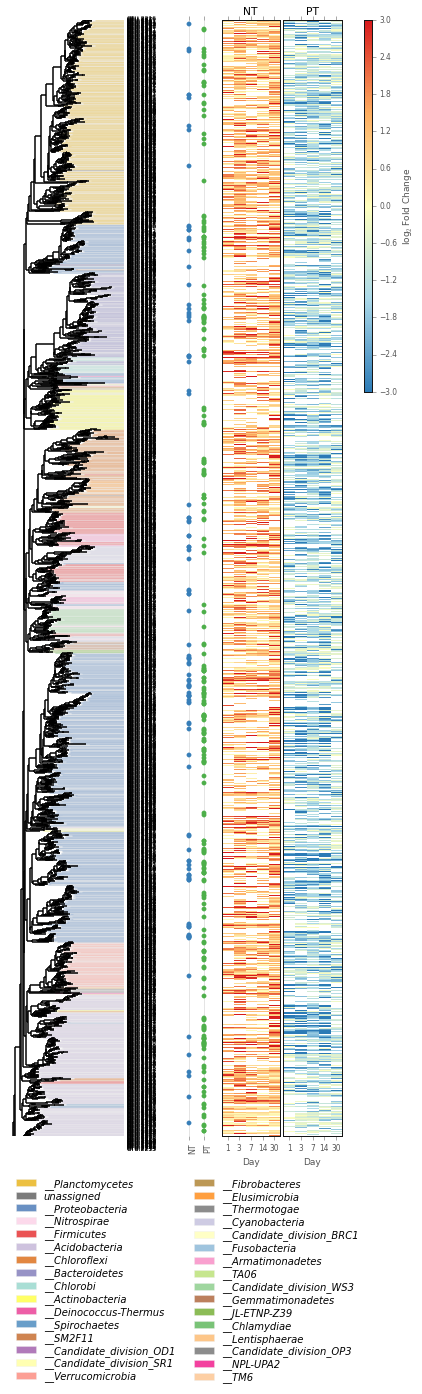

In [15]:
make_tree_fig("Bacteria", "Rank1", "Rank2", "data/l2fc_table_bulk_NTPT", "physeq", 
              save_fn = "figs/tree.png", lw_tax = 1, leg_spacing = 0.03,
              pt_size = 18)

In [12]:
FileLink("/home/chantal/RNASIP/data/figs/ChazyBulkSIP_tree.pdf")

/home/chantal/RNASIP/data/figs/RNADNA_tree.pdf

In [47]:
%%R
df.l2fc = df = read.table("data/l2fc_table_bulk_NTPT", sep=",", header = TRUE, stringsAsFactors = FALSE)
df.l2fc.sub = subset(df, padj <= 0.10)
list.OTUs= select(df.l2fc.sub, OTU)
df.l2fc.OTUs = subset(df, OTU %in% list.OTUs$OTU)
print(head(df.l2fc.OTUs))
write.table(df.l2fc.OTUs, "data/l2fc_table_bulk_NTPTresponders.csv", row.names = FALSE, sep = ",")

   Day Substrate      OTU log2FoldChange     lfcSE      padj    Rank1
9    1       12C  OTU.226    -0.06425983 0.7360697 0.9802853 Bacteria
10   1       12C  OTU.168     1.01478489 1.0904407 0.6786825 Bacteria
11   1       12C OTU.2382    -0.45319470 0.9835664 0.8735299 Bacteria
59   1       12C   OTU.17     0.57457301 0.5785160 0.6558971 Bacteria
76   1       12C  OTU.750     1.78429966 0.7978570 0.3005571 Bacteria
81   1       12C OTU.1389     0.64734111 0.8588938 0.7522088 Bacteria
             Rank2   Rank3                                    Rank4 Rank5 Rank6
9  __Acidobacteria __DA023                                     <NA>  <NA>  <NA>
10 __Acidobacteria __DA023     __uncultured_Acidobacteria_bacterium  <NA>  <NA>
11 __Acidobacteria __DA023     __uncultured_Acidobacteria_bacterium  <NA>  <NA>
59 __Acidobacteria __DA023 __uncultured_Acidobacteriaceae_bacterium  <NA>  <NA>
76 __Acidobacteria __DA023                   __uncultured_bacterium  <NA>  <NA>
81 __Acidobacteria __DA023    

###Tree fxn with no OTUs labled

In [52]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, Till):
    min_padj = l2fc_df[["OTU","padj","Till"]].groupby(["Till","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[Till]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
        
    Day = map(str,[1,3,7,14,30])
    scaleFactor = 0.125
    
    RNA_rspdrs = get_responders(l2fc_df, "NT")
    DNA_rspdrs = get_responders(l2fc_df, "PT")
   

    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Till","Day"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 20]))

    gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[6,2.25,4*.75,4*.75])

    fig = plt.figure()
    fig.set_size_inches((6,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap
    
    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    
    #label_df = edge_df[edge_df["OTU"].notnull()]
    #ax_label = fig.add_subplot(gs[1], sharey = ax1)
    #ax_label.set_frame_on(False)
    #ax_label.set_xticks([])
    #ax_label.set_xticklabels([])
    #ax_label.set_yticks([])
    #for y, l  in zip(label_df.y, label_df.OTU):
     #   ax_label.text(x = 0, y = y - 0.75, s = l, fontsize=6)
    #ax_label.text(x = 0, y = [1,2,3,4,5], s = "test")
    
    ax2 = fig.add_subplot(gs[1], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in RNA_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in DNA_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["NT","PT"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])

    vmin = -5.0 #l2fc_df["log2FoldChange"].quantile(0.05)
    vmax = 5.0 #l2fc_df["log2FoldChange"].quantile(0.95)

    ax3 = fig.add_subplot(gs[2], sharey = ax1)
    ax3.set_xticks(range(len(Day)))
    ax3.set_xticklabels(Day)
    ax3.set_yticklabels([])
    ax3.set_title("NT")
    ax3.set_xlabel("Day")
    df = df_pivot["NT"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[3], sharey = ax3)
    ax4.set_xticks(range(len(Day)))
    ax4.set_xticklabels(Day)
    ax4.set_yticklabels([])
    ax4.yaxis.tick_right()
    ax4.set_title("PT")
    ax4.set_xlabel("Day")
    df = df_pivot["PT"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

###tree fxn with OTUs labeled

In [21]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, Till):
    min_padj = l2fc_df[["OTU","padj","Till"]].groupby(["Till","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[Till]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
        
    Day = map(str,[1,3,7,14,30])
    scaleFactor = 0.125
    
    RNA_rspdrs = get_responders(l2fc_df, "NT")
    DNA_rspdrs = get_responders(l2fc_df, "PT")
   

    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Till","Day"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 20]))

    gs = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[6,2.25,2.25,4*.75,4*.75])

    fig = plt.figure()
    fig.set_size_inches((6,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap
    
    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    
    label_df = edge_df[edge_df["OTU"].notnull()]
    ax_label = fig.add_subplot(gs[1], sharey = ax1)
    ax_label.set_frame_on(False)
    ax_label.set_xticks([])
    ax_label.set_xticklabels([])
    ax_label.set_yticks([])
    for y, l  in zip(label_df.y, label_df.OTU):
        ax_label.text(x = 0, y = y - 0.75, s = l, fontsize=6)
    #ax_label.text(x = 0, y = [1,2,3,4,5], s = "test")
    
    ax2 = fig.add_subplot(gs[2], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in RNA_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in DNA_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["NT","PT"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])

    vmin = -3.0 #l2fc_df["log2FoldChange"].quantile(0.05)
    vmax = 3.0 #l2fc_df["log2FoldChange"].quantile(0.95)

    ax3 = fig.add_subplot(gs[3], sharey = ax1)
    ax3.set_xticks(range(len(Day)))
    ax3.set_xticklabels(Day)
    ax3.set_yticklabels([])
    ax3.set_title("NT")
    ax3.set_xlabel("Day")
    df = df_pivot["NT"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[4], sharey = ax3)
    ax4.set_xticks(range(len(Day)))
    ax4.set_xticklabels(Day)
    ax4.set_yticklabels([])
    ax4.yaxis.tick_right()
    ax4.set_title("PT")
    ax4.set_xlabel("Day")
    df = df_pivot["PT"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

## Tree with only enriched taxa (p.adj <= 0.10) 

Joining by: "OTU"


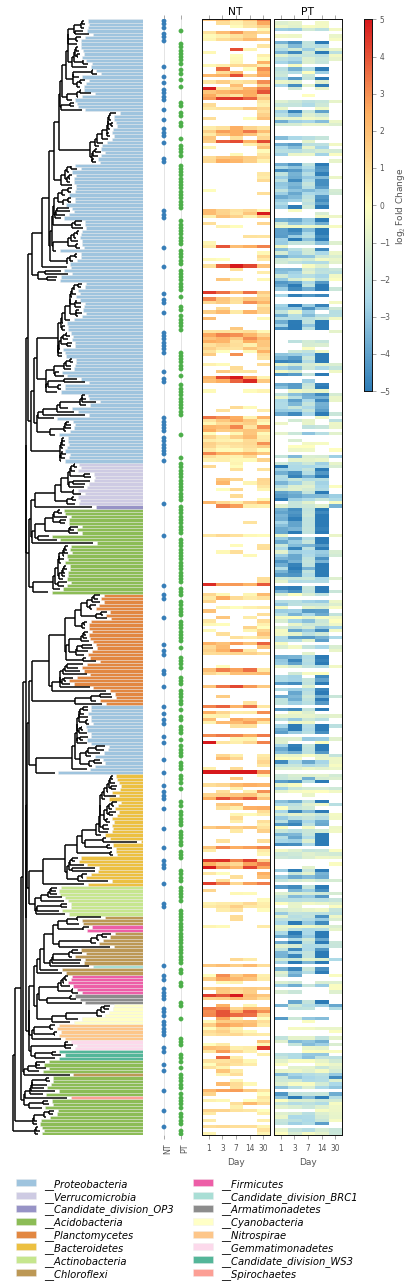

In [53]:
make_tree_fig("Bacteria", "Rank1", "Rank2", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", 
              save_fn = "figs/PTvsNT_tree_responders.pdf", lw_tax = 1, leg_spacing = .03,
              pt_size = 18)

## Phyla-level trees

Joining by: "OTU"


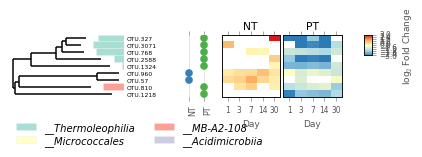

In [23]:
make_tree_fig("__Actinobacteria", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq",
              save_fn = "figs/Actino_tree")

Joining by: "OTU"


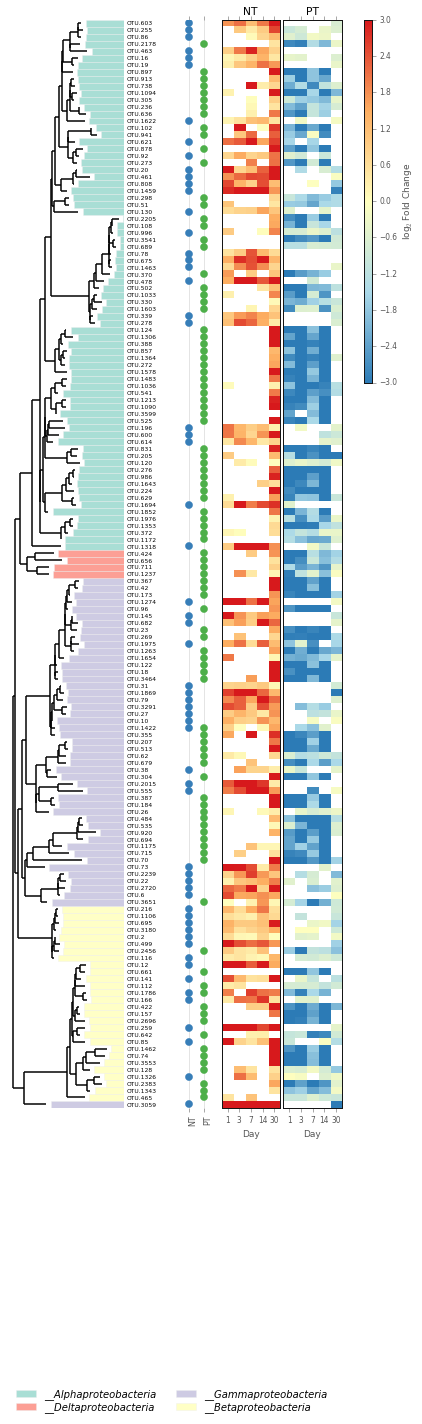

In [24]:
make_tree_fig("__Proteobacteria", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq",
              save_fn = "figs/Proteo_tree")

Joining by: "OTU"


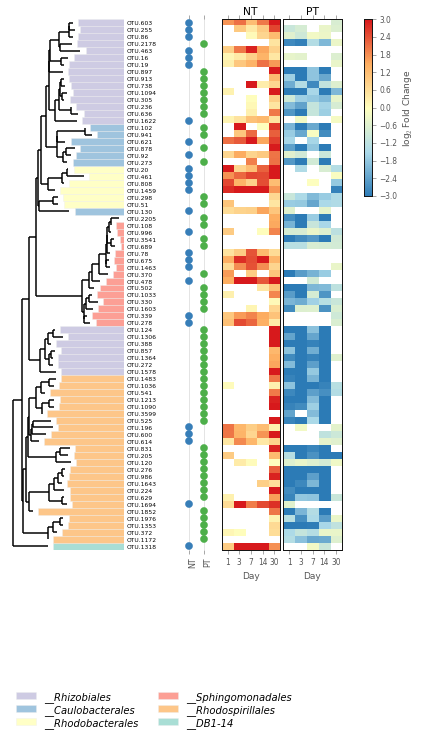

In [26]:
make_tree_fig("__Alphaproteobacteria", "Rank3", "Rank4", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq",
              save_fn = "figs/alphaProteo_tree")

Joining by: "OTU"


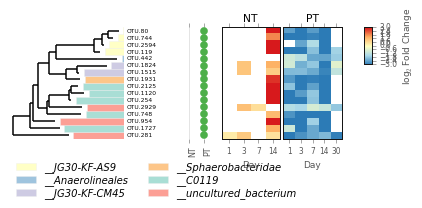

In [28]:
make_tree_fig("__Chloroflexi", "Rank2", "Rank4", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Chloroflexi_tree.pdf")

Joining by: "OTU"


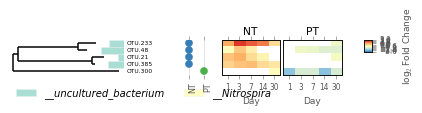

In [29]:
make_tree_fig("__Nitrospirae", "Rank2", "Rank6", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125)

Joining by: "OTU"


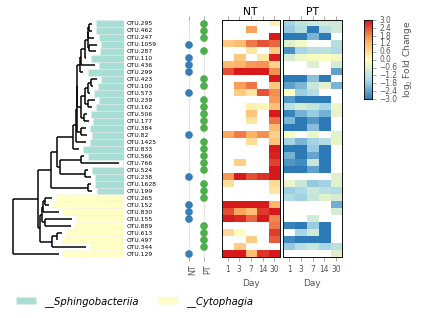

In [30]:
make_tree_fig("__Bacteroidetes", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Bacteroidetes_tree")

Joining by: "OTU"


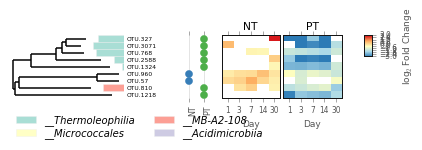

In [31]:
make_tree_fig("__Actinobacteria", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Actino_tree")

Joining by: "OTU"


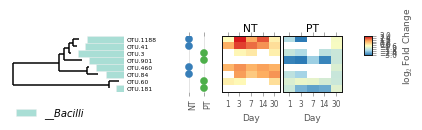

In [33]:
make_tree_fig("__Firmicutes", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Firm_tree")

Joining by: "OTU"


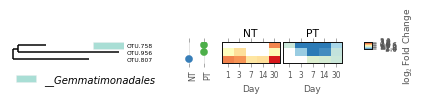

In [34]:
make_tree_fig("__Gemmatimonadetes", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Gem_tree")

Joining by: "OTU"


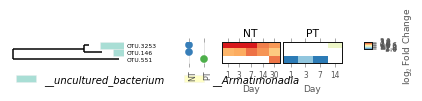

In [35]:
make_tree_fig("__Armatimonadetes", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Armatimon_tree")

Joining by: "OTU"


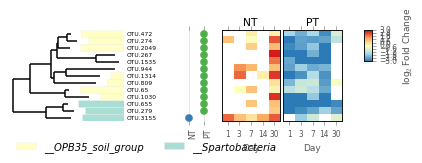

In [36]:
make_tree_fig("__Verrucomicrobia", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Verruco_tree.pdf")

Joining by: "OTU"


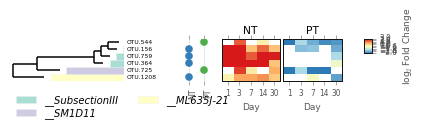

In [37]:
make_tree_fig("__Cyanobacteria", "Rank2", "Rank3", "data/l2fc_table_bulk_NTPTresponders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Bacteroidetes_tree")